In [1]:
# https://analyticsindiamag.com/python-guide-to-googles-t5-transformer-for-text-summarizer/

# Install rust 
#    Rustup
#    curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

# change the runtime and make sure it is set to GPU
# if not then follow this
# Runtime-> Change Runtime -> GPU
# this will restart the runtime so make sure you do it at the start
# hugging face transformers and pytorch lightning latest versions
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7
# you can also check the type of GPU you 
# by running the following command
!nvidia -smi
'''
json for reading html text
pandas for df manipulation
numpy for array operations
torch for pytorch lightning
empty cache utility
'''

torch.cuda.empty_cache()
# path for data
# dataset and dataloader for functions

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
^C
ERROR: Operation cancelled by user
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python

NameError: name 'torch' is not defined

In [2]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
# lightning for data class
import pytorch_lightning as pl
# leveraging the model checkpoints
from pytorch_lightning.callbacks import ModelCheckpoint
# we can visualize performance of model
from pytorch_lightning.loggers import TensorBoardLogger
# splitting the data
from sklearn.model_selection import train_test_split
# color formatting in ANSII code for output in terminal
from termcolor import colored
# wraps the paragraph into a single line or string
import textwrap
# installing multiple utilities
# including optimizer , tokenizer and generation module
from transformers import (
 AdamW,
 T5ForConditionalGeneration,
 T5TokenizerFast as T5Tokenizer
)

# showing bars for processes in notebook
from tqdm.auto import tqdm
# seaborn for visualizing
import seaborn as sns
# procedural import to matplotlib
from pylab import rcParams
# graphs
import matplotlib.pyplot as plt
# rcParams for setting default values to all plots
from matplotlib import rc
# show graphs in the notebook cell

In [3]:
%matplotlib inline
# to render higher resolution images
%config InlineBackend.figure_format='retina'
# setting the default values for plots
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# make sure the fig size is not too big
rcParams['figure.figsize'] = 16, 10
# random pseudo numbers
pl.seed_everything(42) 

Global seed set to 42


42

In [6]:
# taking a look at the data by df
df = pd.read_csv("news_summary.csv", encoding='latin-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
# slicing out useful columns
df = df[['text', 'ctext']]
# show the first 5 data points
df.head()

# changing the names of the columns
df.columns = ['summary', 'text']
# dropping out the Not Available values
df = df.dropna()
df.head()

# using sklearn utility, splitting the data into 10:1 ratio
train_df, test_df = train_test_split(df, test_size=0.1)
# let's check the shape of our data
train_df.shape, test_df.shape 

((3956, 2), (440, 2))

In [10]:
# class for creating the dataset which extends from pytorch 
class NewsSummaryDataset(Dataset):
	# init it , create a constructor
	def __init__(
		self,
		# data in the form of a dataframe
		data: pd.DataFrame,
		# a tokenizer
		tokenizer: T5Tokenizer,
		# max token length of input sequence
		text_max_token_len: int = 512,
		# same for the summary but less length
		summary_max_token_len: int = 128
	):
		# saving all
		self.tokenizer = tokenizer
		self.data = data
		self.text_max_token_len = text_max_token_len
		self.summary_max_token_len = summary_max_token_len

	# length method
	def __len__(self):
		return len(self.data)

	# getting the items method  
	def __getitem__(self, index: int):
		# data row from data at current index
		data_row = self.data.iloc[index]
		# get the full text
		text = data_row['text']
		# encoding the text
		text_encoding = tokenizer(
			text,
			# setting max length
			max_length=self.text_max_token_len,
			# for same length
			padding='max_length',
			# cutting longer sequences
			truncation=True,
			# masking unwanted words
			return_attention_mask=True,
			# special tokens for start and end
			add_special_tokens=True,
			# return pytorch tensors
			return_tensors='pt'
		)
		# same is done with summary encoding
		summary_encoding = tokenizer(
			data_row['summary'],
			truncation=True,
			return_attention_mask=True,
			add_special_tokens=True,
			max_length=self.summary_max_token_len,
			padding='max_length',
			return_tensors='pt'
		)
		# creating the actual labels
		labels = summary_encoding['input_ids'] 
		labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation

		return dict(
			# data
			text=text,
			# task
			summary=data_row['summary'],
			# easy batching
			text_input_ids=text_encoding['input_ids'].flatten(),
			# masking
			text_attention_mask=text_encoding['attention_mask'].flatten(),
			# again flatten
			labels=labels.flatten(),
			labels_attention_mask=summary_encoding['attention_mask'].flatten()
		)

In [12]:
# data module for pytorch lightning
class NewsSummaryDataModule(pl.LightningDataModule):
	def __init__(
		self,
		# pass in train data
		train_df: pd.DataFrame,
		# pass in test data
		test_df: pd.DataFrame,
		# tokenizer
		tokenizer: T5Tokenizer,
		# batch_size
		batch_size: int = 8,
		# length of sequence
		text_max_token_len: int = 512,
		# length of output sequence
		summary_max_token_len: int = 128
	):
		super().__init__()
		# storing the data in class objects
		self.train_df = train_df
		self.test_df = test_df
		self.batch_size = batch_size
		self.tokenizer = tokenizer
		self.text_max_token_len = text_max_token_len
		self.summary_max_token_len = summary_max_token_len
	# automatically called by the trainer  
	def setup(self, stage=None):
		self.train_dataset = NewsSummaryDataset(
			self.train_df,
			self.tokenizer,
			self.text_max_token_len,
			self.summary_max_token_len
		)
		self.test_dataset = NewsSummaryDataset(
			self.test_df,
			self.tokenizer,
			self.text_max_token_len,
			self.summary_max_token_len
		)
	# for train data
	def train_dataloader(self):
		return DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			shuffle=True,
			num_workers=2
		)
   	# for test data
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			shuffle=True,
			num_workers=2
		)
	# valid data
	def val_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			shuffle=True,
			num_workers=2
		) 

/opt/homebrew/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1223 > 512). Running this sequence through the model will result in indexing errors


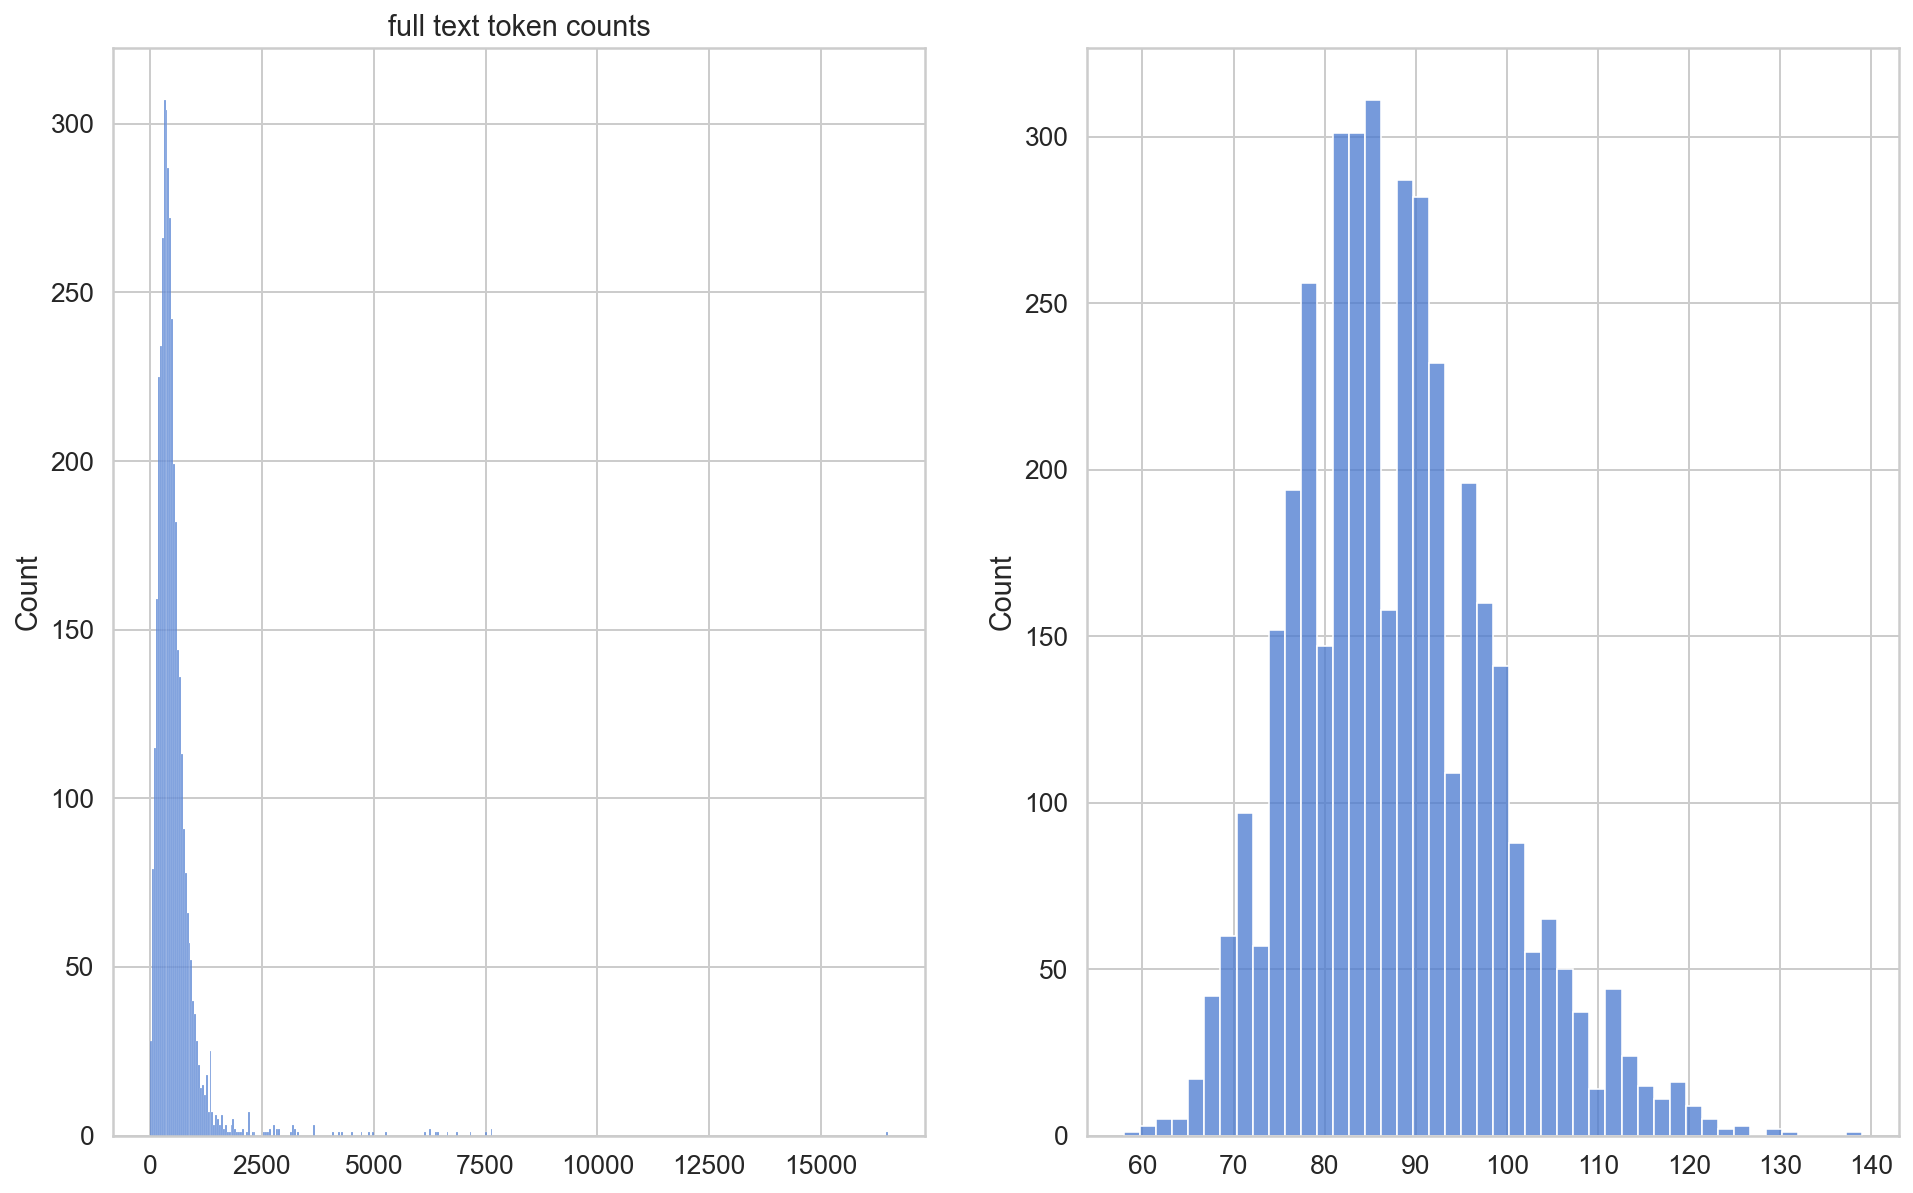

In [14]:
# leveraging the base T5 transformer
MODEL_NAME = 't5-base'
# instantiate the tokenizer
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
# empty lists which are to be filled
text_token_counts, summary_token_counts = [], []

# traversing train data
for _, row in train_df.iterrows():
	# encode the data points
	text_token_count = len(tokenizer.encode(row['text']))
	text_token_counts.append(text_token_count)
	# do the same with the summary
	summary_token_count = len(tokenizer.encode(row['summary']))
	summary_token_counts.append(summary_token_count) 
    
# plotting for token lengths and counts
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)

# the same for summary
ax1.set_title('full text token counts')
sns.histplot(summary_token_counts, ax=ax2)

# number of epochs is less because number of parameters is high
N_EPOCHS = 3
BATCH_SIZE = 8
# call the data module
data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

In [15]:
# create lightning module for summarization
class NewsSummaryModel(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

	def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
		output = self.model(
			input_ids,
			attention_mask=attention_mask,
			labels=labels,
			decoder_attention_mask=decoder_attention_mask
		)
		return output.loss, output.logits

	def training_step(self, batch, batch_size):
		input_ids = batch['text_input_ids']
		attention_mask = batch['text_attention_mask']
		labels = batch['labels']
		labels_attention_mask = batch['labels_attention_mask']
		loss, outputs = self(
			input_ids=input_ids,
			attention_mask=attention_mask,
			decoder_attention_mask=labels_attention_mask,
			labels=labels
		)
		self.log("train_loss", loss, prog_bar=True, logger=True)
		return loss

	def validation_step(self, batch, batch_size):
		input_ids = batch['text_input_ids']
		attention_mask = batch['text_attention_mask']
		labels = batch['labels']
		labels_attention_mask = batch['labels_attention_mask']
		loss, outputs = self(
			input_ids=input_ids,
			attention_mask=attention_mask,
			decoder_attention_mask=labels_attention_mask,
			labels=labels
		)
		self.log("val_loss", loss, prog_bar=True, logger=True)
		return loss

	def test_step(self, batch, batch_size):
		input_ids = batch['text_input_ids']
		attention_mask = batch['text_attention_mask']
		labels = batch['labels']
		labels_attention_mask = batch['labels_attention_mask']
		loss, outputs = self(
			input_ids=input_ids,
			attention_mask=attention_mask,
			decoder_attention_mask=labels_attention_mask,
			labels=labels
		)
		self.log("test_loss", loss, prog_bar=True, logger=True)
		return loss

	def configure_optimizers(self):
		return AdamW(self.parameters(), lr=0.0001)

In [ ]:
model = NewsSummaryModel()
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs
checkpoint_callback = ModelCheckpoint(
	dirpath='checkpoints',
	filename='best-checkpoint',
	save_top_k=1,
	verbose=True,
	monitor='val_loss',
	mode='min'
)


logger = TensorBoardLogger("lightning_logs", name='news-summary')
trainer = pl.Trainer(
	logger=logger,
	checkpoint_callback=checkpoint_callback,
	max_epochs=N_EPOCHS,
	gpus=1,
	progress_bar_refresh_rate=30
)


trainer.fit(model, data_module)
trained_model = NewsSummaryModel.load_from_checkpoint(
	trainer.checkpoint_callback.best_model_path
)
trained_model.freeze() 

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
def summarizeText(text):
	text_encoding = tokenizer(
		text,
		max_length=512,
		padding='max_length',
		truncation=True,
		return_attention_mask=True,
		add_special_tokens=True,
		return_tensors='pt'
	)
	generated_ids = trained_model.model.generate(
		input_ids=text_encoding['input_ids'],
		attention_mask=text_encoding['attention_mask'],
		max_length=150,
		num_beams=2,
		repetition_penalty=2.5,
		length_penalty=1.0,
		early_stopping=True
	)
	preds = [
			tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
			for gen_id in generated_ids
	]
	return "".join(preds)

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row['text']
model_summary = summarizeText(text)
text
sample_row['summary']
model_summary
sample_row = test_df.iloc[1]
text = sample_row['text']
model_summary = summarizeText(text)
text
sample_row['summary']
Model_summary 

In [ ]:
import pickle

filename = open('text_summarization_model.pkl', 'wb')
pickle.dump(trained_model.model, filename)
# saving the model
model = pickle.load(open('text_summarization_model.pkl', 'rb'))
# function for producing output provided input
def summarizeText(text):
	text_encoding = tokenizer(
		text,
		max_length=512,
		padding='max_length',
		truncation=True,
		return_attention_mask=True,
		add_special_tokens=True,
		return_tensors='pt'
	)
	generated_ids = model.generate(
		input_ids=text_encoding['input_ids'],
		attention_mask=text_encoding['attention_mask'],
		max_length=150,
		num_beams=2,
		repetition_penalty=2.5,
		length_penalty=1.0,
		early_stopping=True
	)
	preds = [
			tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
			for gen_id in generated_ids
	]
	return "".join(preds) 